# Продвинутные методы глубокого обучения. Домашнее задание

Соревнование на Kaggle  
https://www.kaggle.com/competitions/dl-captcha-new/

задача из области компьютерного зрения – распознавание букв английского алфавита на искаженных и зашумленных изображениях.

Данные для обучения содержатся в двух файлах: images.npy и labels.npy. Это формат numpy-массивов.

Всего доступно 20 тысяч размеченных изображений размером 48x48 с 3 цветовыми каналами (RGB), поэтому массив images имеет размер (20000, 48, 48, 3). В массиве labels содержатся ответы к тренировочному набору изображений. В английском алфавите 26 букв: 0-й класс соответствует букве А и так далее по алфавиту, 25-й класс — буква Z.

Ваша задача — обучить нейронную сеть и с ее помощью предсказать метки классов для изображений из файла images_sub.npy, в нем 50 тысяч изображений. Посмотрите на структуру файла sample_submission.csv — он не содержит полезных данных, а лишь описывает формат, в котором вы загружаете ваши предсказания на сайт. Создайте из ваших предсказаний такой же файл и загрузите в качестве вашего ответа (сабмита). Вы можете делать до 20 сабмитов в сутки.

Метрика лидерборда — accuracy, то есть доля правильно распознанных изображений.

Нотбук с базовым решением расположен в Google Colab. Попробуйте решить задачу, не обращаясь к нему. Задача будет считаться решенной, если в Public Leaderboard вы наберете score, который будет равен или больше 0.82.

In [ ]:
! pip install tensorflow.keras

In [ ]:
! pip install opendatasets

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/competitions/dl-captcha-new'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anastasiays
Your Kaggle Key: ··········
Your Kaggle Key: ··········


100%|██████████| 323M/323M [00:00<00:00, 375MB/s]



Extracting archive ./dl-captcha-new/dl-captcha-new.zip to ./dl-captcha-new


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [38]:
# Загружаем данные
images = np.load('./dl-captcha-new/mds-misis-dl-captchan/images.npy')
labels = np.load('./dl-captcha-new/mds-misis-dl-captchan/labels.npy')
images_sub = np.load('./dl-captcha-new/mds-misis-dl-captchan/images_sub.npy')

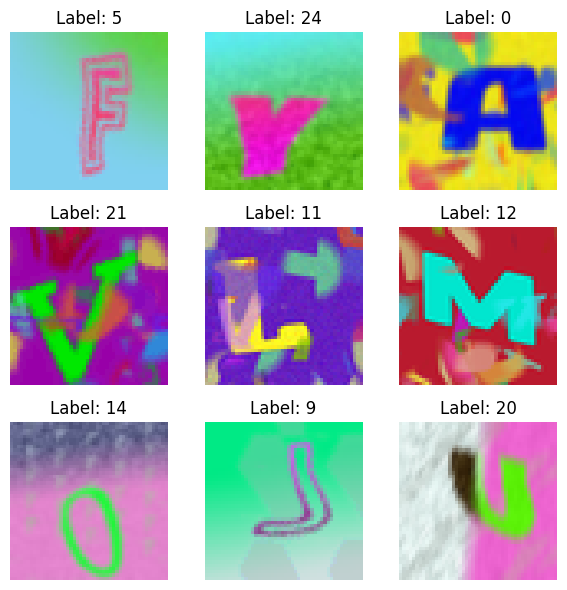

In [40]:
# Отобразим несколько изображения набора
num_images = 9

# Выбираем случайные индексы
indices = np.random.choice(len(images), size=num_images, replace=False)

plt.figure(figsize=(6, 6))

for i, idx in enumerate(indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[idx])
    plt.axis('off')
    plt.title(f"Label: {labels[idx]}")

plt.tight_layout()
plt.show()

In [ ]:
labels

array([13, 24,  8, ..., 21,  7, 18])

In [41]:
# Приводим к типу float32 (современные GPU оптимизированы для работы с этим типом данных )
# и Нормализуем (приводим пиксели в диапазон [0, 1])
images = images.astype('float32') / 255.0
test_images = images_sub.astype('float32') / 255.0

# Категоризация
# Используем one-hot encoding
labels = to_categorical(labels, num_classes=26)

In [43]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
# Разделяем на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [45]:
# Создаем CNN модель
model = Sequential([
    # 1 слой: свертка + MaxPooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)), # 32 фильтра 3x3
    MaxPooling2D((2, 2)), # уменьшение размерности в 2 раза
    # 2 слой: свертка + MaxPooling
    Conv2D(64, (3, 3), activation='relu'), # 64 фильтра 3x3
    MaxPooling2D((2, 2)),
    # 3 слой: свертка + BatchNormalization + MaxPooling
    Conv2D(128, (3, 3), activation='relu'), # 128 фильтра 3x3
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Вытягиваем 3D-тензор в 1D вектор
    Flatten(),
    # Полносвязные слои
    Dense(256, activation='relu'), # 256 нейронов
    Dropout(0.5),   # dropout 50% нейронов для регуляризации
    # Выходной слой (26 классов для букв англ алфавита)
    Dense(26, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Используем оптимизатор Adam, кроссэнтропию как функцию потерь и указываем метрику для оценки в соотвесттвии с заданием

In [46]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624,986 (2.38 MB)

 Trainable params: 624,730 (2.38 MB)

 Non-trainable params: 256 (1.00 KB)

In [47]:
%%time
# Обучаем модель
# коллбэк, предотвращающий переобучение, делая раннюю остановку, если качество
# на валидационной выборке не улучшается 5 эпох
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# коллбэк для уменьшения скорости обучения если модель не улучшается
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 259ms/step - accuracy: 0.0706 - loss: 3.2493 - val_accuracy: 0.1138 - val_loss: 3.0846 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 246ms/step - accuracy: 0.3378 - loss: 2.2247 - val_accuracy: 0.5015 - val_loss: 1.8167 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 251ms/step - accuracy: 0.5274 - loss: 1.5487 - val_accuracy: 0.6342 - val_loss: 1.2008 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 245ms/step - accuracy: 0.6166 - loss: 1.2195 - val_accuracy: 0.6335 - val_loss: 1.1865 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 245ms/step - accuracy: 0.6832 - loss: 1.0147 - val_accuracy: 0.6848 - val_loss: 1.0174 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 249ms/step - accuracy: 0.7325 - loss: 0.8431 - val_accuracy: 0.7415 - val_loss: 0.8369 - learning_rate: 0.0010
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 256ms/step - accuracy: 0.7

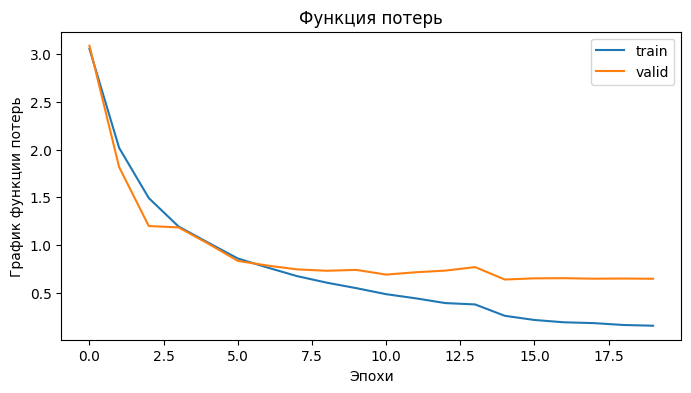

In [48]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Функция потерь')
plt.xlabel('Эпохи')
plt.ylabel('График функции потерь')
plt.legend()
plt.show()

In [49]:
# Предсказание на тестовых данных
predictions = model.predict(test_images)
pred_classes = np.argmax(predictions, axis=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step


In [50]:
letters = [chr(i) for i in range(65, 91)]  # через ASCII-коды (A=65, Z=90)

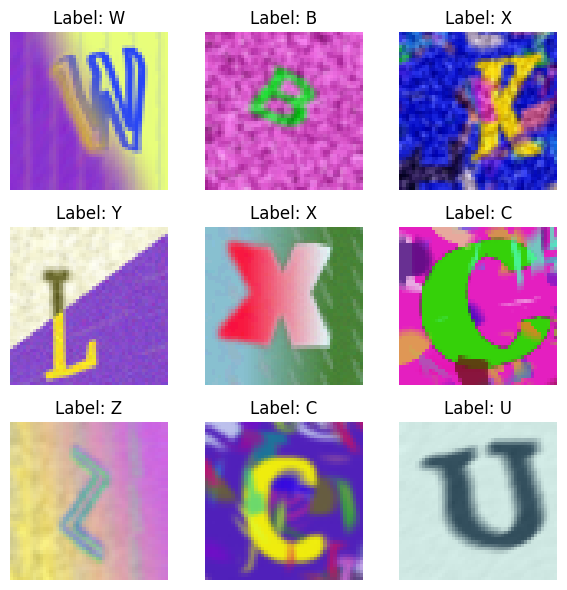

In [51]:
# Выведем несколько случайных элементов тестовой выборки

num_images = 9
indices = np.random.choice(len(test_images), size=num_images, replace=False)

plt.figure(figsize=(6, 6))

for i, idx in enumerate(indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[idx])
    plt.axis('off')
    plt.title(f"Label: {letters[pred_classes[idx]]}")

plt.tight_layout()
plt.show()

In [ ]:
# Посмотрим как должен выглядеть файл sample_submission
sample_submission = pd.read_csv('./dl-captcha-new/mds-misis-dl-captchan/sample_submission.csv')
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Id        50000 non-null  int64
 1   Category  50000 non-null  int64
dtypes: int64(2)
memory usage: 781.4 KB


In [52]:
# Создаем submission файл
submission = pd.DataFrame({
    'Id': range(len(pred_classes)),
    'Category': pred_classes
})

# Сохраняем файл
submission.to_csv('submission.csv', index=False)
print("Файл сохранен")

Файл сохранен


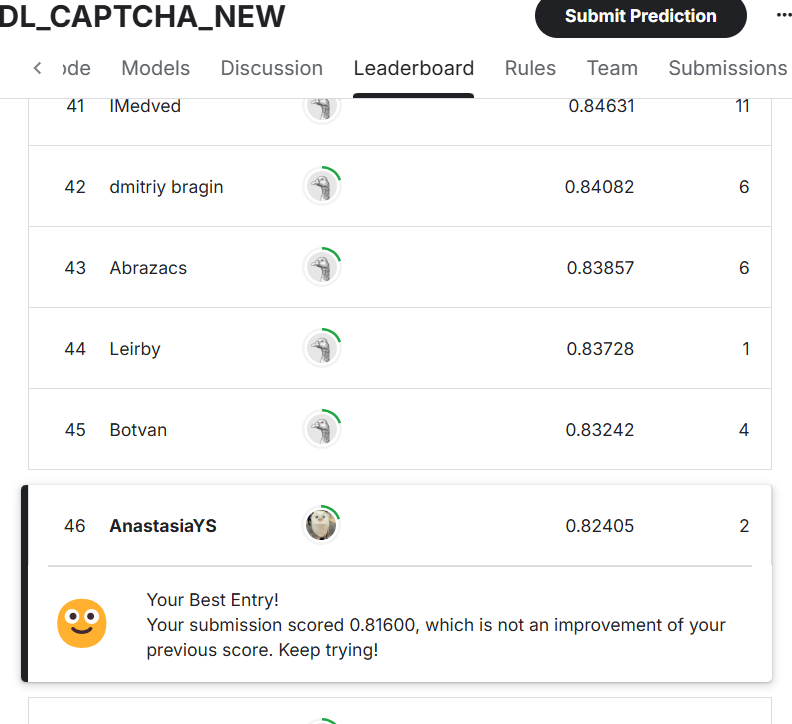


Попробуем улучшить, добавив в модель нормализацию в слои и обучив с аугментацией данных

In [55]:
# Создаем CNN модель
model = Sequential([
    # 1 слой: свертка + BatchNormalization + MaxPooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)), # 32 фильтра 3x3
    BatchNormalization(),  # нормализация
    MaxPooling2D((2, 2)), # уменьшение размерности в 2 раза
    # 2 слой: свертка + BatchNormalization + MaxPooling
    Conv2D(64, (3, 3), activation='relu'), # 64 фильтра 3x3
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # 3 слой: свертка + BatchNormalization + MaxPooling
    Conv2D(128, (3, 3), activation='relu'), # 128 фильтра 3x3
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Вытягиваем 3D-тензор в 1D вектор
    Flatten(),
    # Полносвязные слои
    Dense(256, activation='relu'), # 256 нейронов
    Dropout(0.5),   # dropout 50% нейронов для регуляризации
    # Выходной слой (26 классов для букв англ алфавита)
    Dense(26, activation='softmax')
])

In [56]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 625,370 (2.39 MB)

 Trainable params: 624,922 (2.38 MB)

 Non-trainable params: 448 (1.75 KB)

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [59]:
%%time
# Обучаем модель
# коллбэк, предотвращающий переобучение, делая раннюю остановку, если качество
# на валидационной выборке не улучшается 5 эпох
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# коллбэк для уменьшения скорости обучения если модель не улучшается
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# добавим аугментацию данных
history = model.fit(
    ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=False).flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 108s 406ms/step - accuracy: 0.0445 - loss: 3.6049 - val_accuracy: 0.0500 - val_loss: 3.3731 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 112s 450ms/step - accuracy: 0.0685 - loss: 3.1675 - val_accuracy: 0.1625 - val_loss: 2.8239 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 108s 432ms/step - accuracy: 0.1334 - loss: 2.8760 - val_accuracy: 0.3377 - val_loss: 2.2298 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 104s 416ms/step - accuracy: 0.2230 - loss: 2.5554 - val_accuracy: 0.4455 - val_loss: 1.8522 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 406ms/step - accuracy: 0.2842 - loss: 2.2979 - val_accuracy: 0.5430 - val_loss: 1.5216 - learning_rate: 0.0010
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 418ms/step - accuracy: 0.3581 - loss: 2.0677 - val_accuracy: 0.5763 - val_loss: 1.3890 - learning_rate: 0.0010
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 402ms/step - accuracy: 0.4081 

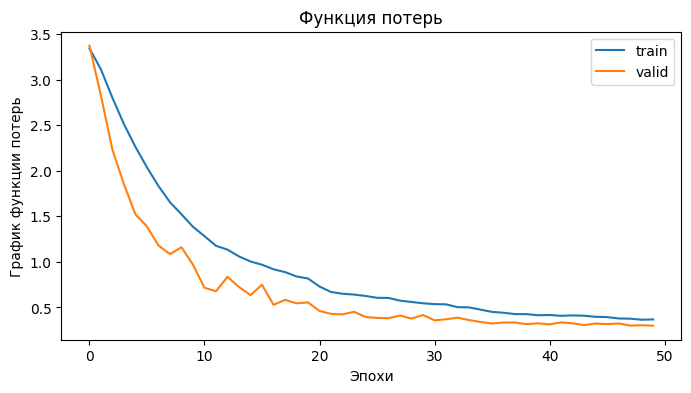

In [60]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Функция потерь')
plt.xlabel('Эпохи')
plt.ylabel('График функции потерь')
plt.legend()
plt.show()

In [61]:
# Предсказание на тестовых данных
predictions = model.predict(test_images)
pred_classes = np.argmax(predictions, axis=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 64s 40ms/step


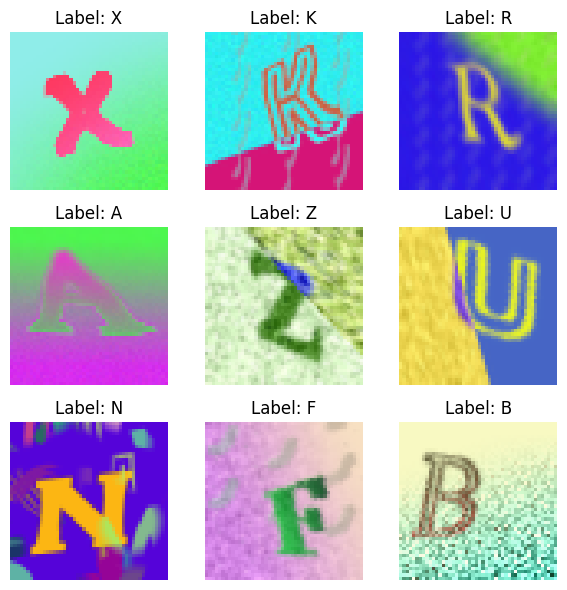

In [62]:
# Выведем несколько случайных элементов тестовой выборки

num_images = 9
indices = np.random.choice(len(test_images), size=num_images, replace=False)

plt.figure(figsize=(6, 6))

for i, idx in enumerate(indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[idx])
    plt.axis('off')
    plt.title(f"Label: {letters[pred_classes[idx]]}")

plt.tight_layout()
plt.show()

In [63]:
# Создаем submission файл
submission = pd.DataFrame({
    'Id': range(len(pred_classes)),
    'Category': pred_classes
})

# Сохраняем файл
submission.to_csv('submission.csv', index=False)
print("Файл сохранен")

Файл сохранен


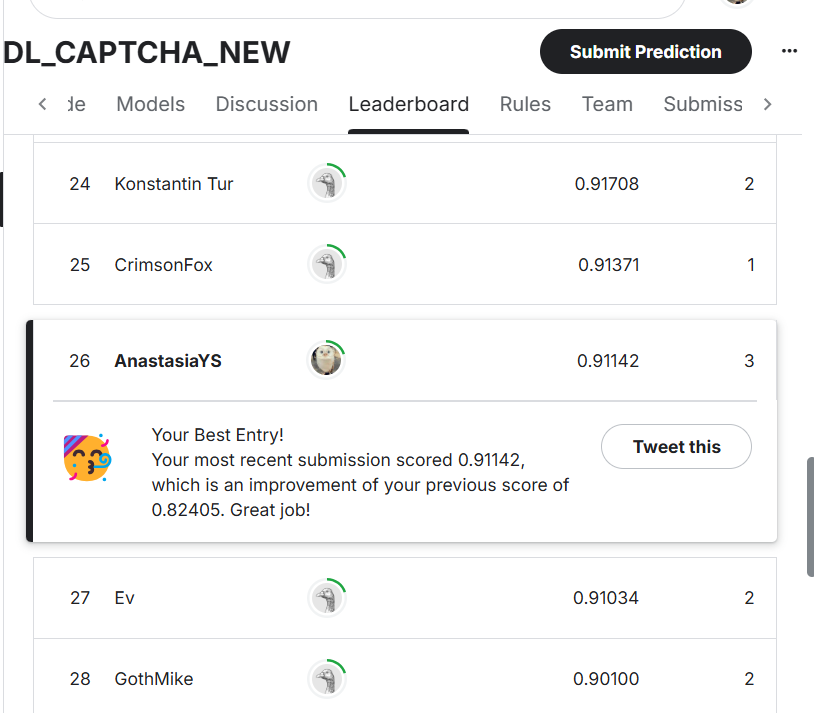

Результат улучшился!